# Introductory Notebook
set up material project api using instructions at: https://materialsproject.org/open

In [ ]:
from pymatgen.ext.matproj import MPRester
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.composition import ElementProperty, ElementFraction, Meredig, Stoichiometry
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from materials_project_api_key import api_key as api_key

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

: 

In [2]:
# Lets get some data to work with
# Searching for all Silicon containing materials
criteria = {"elements": {"$all": ["Si"]}}
# Properties we want to retrieve
properties = ["material_id",'formula','spacegroup.symbol','structure',"band_gap"] 
with MPRester(api_key) as m:
    data = m.query(criteria=criteria,properties=properties)
data = pd.DataFrame(data)

100%|█████████████████████████████████████████████████| 8969/8969 [01:06<00:00, 135.65it/s]


In [3]:
data.head(5)

,material_id,formula,spacegroup.symbol,structure,band_gap
0,mp-1001113,{'Si': 1.0},Cmcm,"[[ 1.6312 -3.73415914 2.99381475] Si, [ 1...",0.0000
1,mp-1002206,"{'Si': 1.0, 'C': 1.0}",Fm-3m,"[[0. 0. 0.] Si, [2.0251 2.0251 2.0251] C]",0.0000
2,mp-10064,"{'Si': 1.0, 'O': 2.0}",Fm-3m,"[[0. 0. 0.] Si, [1.145708 1.145708 1.145708] O...",1.9997
3,mp-1009,"{'Sr': 1.0, 'Si': 6.0}",Cmcm,"[[2.244513 2.3181204 2.92729125] Sr, [ 2.24...",0.0000
4,mp-1009733,"{'Ca': 2.0, 'Si': 1.0}",Fm-3m,"[[5.3766165 5.3766165 5.3766165] Ca, [1.792205...",0.6810


In [4]:
# Lets use only semiconductors
semiconductors = data.loc[data.band_gap > 0]

In [5]:
semiconductors = StrToComposition().featurize_dataframe(semiconductors, "formula")

StrToComposition:   0%|          | 0/4600 [00:00<?, ?it/s]

In [6]:
semiconductors.head(5)

,material_id,formula,spacegroup.symbol,structure,band_gap,composition
2,mp-10064,"{'Si': 1.0, 'O': 2.0}",Fm-3m,"[[0. 0. 0.] Si, [1.145708 1.145708 1.145708] O...",1.9997,"(Si, O)"
4,mp-1009733,"{'Ca': 2.0, 'Si': 1.0}",Fm-3m,"[[5.3766165 5.3766165 5.3766165] Ca, [1.792205...",0.6810,"(Ca, Si)"
8,mp-1021503,"{'Si': 1.0, 'O': 2.0}",Pn-3m,"[[1.903522 1.903522 1.903522] Si, [0. 0. 0.] S...",4.5852,"(Si, O)"
10,mp-1023900,"{'Si': 1.0, 'S': 1.0}",Pmna,"[[2.9890725 4.982175 0.65573037] Si, [2.989...",0.4875,"(Si, S)"
16,mp-1072544,{'Si': 1.0},Im-3m,[[2.22044605e-16 3.36600800e+00 1.68300400e+00...,0.1909,(Si)


In [7]:
# Define the featuriser
ep_feat = ElementProperty.from_preset(preset_name="magpie")
# input the "composition" column to the featuriser
X_desc = ep_feat.featurize_dataframe(semiconductors, col_id="composition").iloc[:,6:]
print(X_desc.shape)
X_desc.head(5)

ElementProperty:   0%|          | 0/4600 [00:00<?, ?it/s]

(4600, 132)


,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
2,8.0,14.0,6.0,10.0,2.666667,8.0,78.0,87.0,9.0,84.000000,...,0.0,0.0,0.0,0.0,12.0,227.0,215.0,83.666667,95.555556,12.0
4,14.0,20.0,6.0,18.0,2.666667,20.0,7.0,78.0,71.0,30.666667,...,0.0,0.0,0.0,0.0,225.0,227.0,2.0,225.666667,0.888889,225.0
8,8.0,14.0,6.0,10.0,2.666667,8.0,78.0,87.0,9.0,84.000000,...,0.0,0.0,0.0,0.0,12.0,227.0,215.0,83.666667,95.555556,12.0
10,14.0,16.0,2.0,15.0,1.000000,14.0,78.0,88.0,10.0,83.000000,...,0.0,0.0,0.0,0.0,70.0,227.0,157.0,148.500000,78.500000,70.0
16,14.0,14.0,0.0,14.0,0.000000,14.0,78.0,78.0,0.0,78.000000,...,0.0,0.0,0.0,0.0,227.0,227.0,0.0,227.000000,0.000000,227.0


In [8]:
# Drop columns (descriptors) with nan values
X_desc = X_desc.dropna(how='any',axis=1)
# Ensure dtype is float32
columns = X_desc.columns
X_desc = pd.DataFrame(np.array(X_desc,dtype=np.float32),columns=columns)
print(X_desc.shape)
X_desc.head(5)

(4600, 122)


,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,8.0,14.0,6.0,10.0,2.666667,8.0,78.0,87.0,9.0,84.000000,...,0.0,0.0,0.0,0.0,12.0,227.0,215.0,83.666664,95.555557,12.0
1,14.0,20.0,6.0,18.0,2.666667,20.0,7.0,78.0,71.0,30.666666,...,0.0,0.0,0.0,0.0,225.0,227.0,2.0,225.666672,0.888889,225.0
2,8.0,14.0,6.0,10.0,2.666667,8.0,78.0,87.0,9.0,84.000000,...,0.0,0.0,0.0,0.0,12.0,227.0,215.0,83.666664,95.555557,12.0
3,14.0,16.0,2.0,15.0,1.000000,14.0,78.0,88.0,10.0,83.000000,...,0.0,0.0,0.0,0.0,70.0,227.0,157.0,148.500000,78.500000,70.0
4,14.0,14.0,0.0,14.0,0.000000,14.0,78.0,78.0,0.0,78.000000,...,0.0,0.0,0.0,0.0,227.0,227.0,0.0,227.000000,0.000000,227.0


In [9]:
# Normalise the data by removing the mean and scaling to unit variance
X_desc = (X_desc - np.mean(X_desc,axis=0)) / np.std(X_desc,axis=0)
# Drop columns (descriptors) with nan values
X_desc = X_desc.dropna(how='any',axis=1)

In [10]:
X_desc.head(5)

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,0.409677,-1.052486,-1.168377,-0.565271,-0.804313,-0.191618,1.710625,-0.154266,-1.708337,1.161430,...,-0.40991,-0.342084,-0.36663,-0.027494,-0.365091,-1.086792,0.344178,-0.732795,0.321950,-0.440850
1,2.155947,-0.748881,-1.168377,0.613370,-0.804313,1.626723,-0.625241,-2.934664,0.309328,-4.674500,...,-0.40991,-0.342084,-0.36663,-0.027494,3.516796,-1.086792,-3.524507,2.950406,-2.987968,2.808955
2,0.409677,-1.052486,-1.168377,-0.565271,-0.804313,-0.191618,1.710625,-0.154266,-1.708337,1.161430,...,-0.40991,-0.342084,-0.36663,-0.027494,-0.365091,-1.086792,0.344178,-0.732795,0.321950,-0.440850
3,2.155947,-0.951284,-1.378825,0.171380,-1.106215,0.717553,1.710625,0.154667,-1.675794,1.052007,...,-0.40991,-0.342084,-0.36663,-0.027494,0.691949,-1.086792,-0.709267,0.948854,-0.274379,0.444074
4,2.155947,-1.052486,-1.484049,0.024050,-1.287356,0.717553,1.710625,-2.934664,-2.001223,0.504888,...,-0.40991,-0.342084,-0.36663,-0.027494,3.553246,-1.086792,-3.560833,2.984990,-3.019047,2.839469


In [11]:
# Generating train test split
X = X_desc
y = semiconductors.band_gap
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [12]:
# Training arandom forest model
rf = RandomForestRegressor(n_estimators=500,random_state = 128)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=128)

In [13]:
# Getting some predictions
tr_preds = rf.predict(X_train)
te_preds = rf.predict(X_test)

In [14]:
# Calculate Scores
tr_mse = mse(y_train,tr_preds)
te_mse = mse(y_test,te_preds)
print(f'Train MSE: {tr_mse:.3f} eV | Test MSE: {te_mse:.3f} eV')

Train MSE: 0.306 eV | Test MSE: 0.939 eV


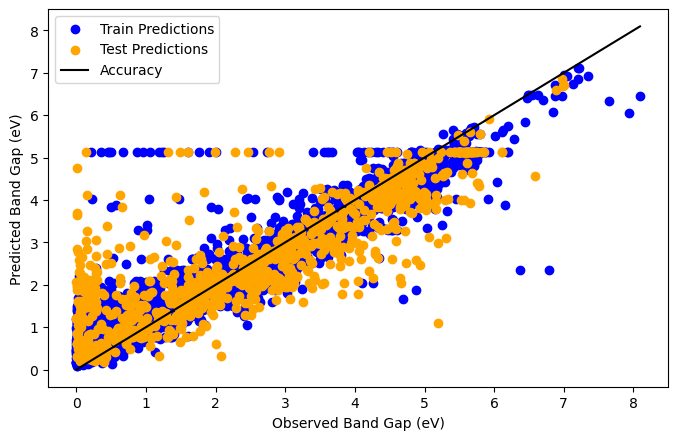

In [15]:
# Plot the first predictions
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
ax.scatter(y_train,tr_preds,color='blue',label='Train Predictions')
ax.scatter(y_test,te_preds,color='orange',label='Test Predictions')
acc = np.linspace(min(y),max(y),1000)
ax.plot(acc,acc,color='k',label='Accuracy')
ax.set_xlabel('Observed Band Gap (eV)')
ax.set_ylabel('Predicted Band Gap (eV)')
plt.legend()

Text(0, 0.5, 'Count')

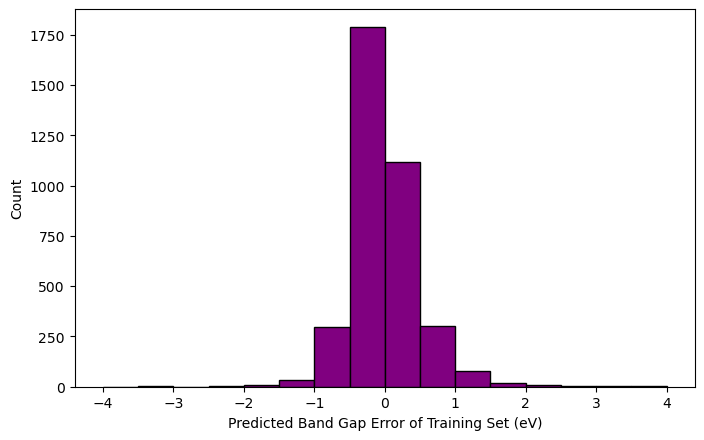

In [16]:
# Distribution of training errors
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
tr_errors = tr_preds - y_train
ax.hist(tr_errors,color='purple',edgecolor='k',bins=np.linspace(-4,4,17))
ax.set_xlabel('Predicted Band Gap Error of Training Set (eV)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

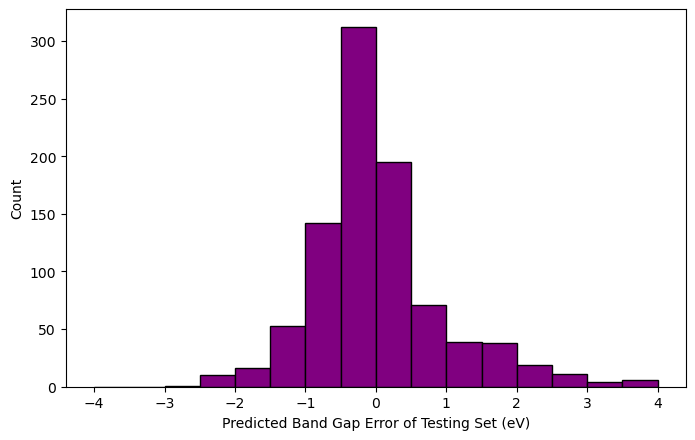

In [17]:
# Distribution of test errors
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
te_errors = te_preds - y_test
ax.hist(te_errors,color='purple',edgecolor='k',bins=np.linspace(-4,4,17))
ax.set_xlabel('Predicted Band Gap Error of Testing Set (eV)')
ax.set_ylabel('Count')

In [18]:
# We could also do a pca
pca = PCA(n_components=32)
X_pca = pca.fit_transform(X_desc)
print(pca.explained_variance_ratio_[:10])
print(sum(pca.explained_variance_ratio_))

[0.17983614 0.1552728  0.11951051 0.07978603 0.06967515 0.0514122
 0.04088773 0.03283711 0.02869442 0.026214  ]
0.969266070984304


Text(0, 0.5, 'Principal Component dimension 1')

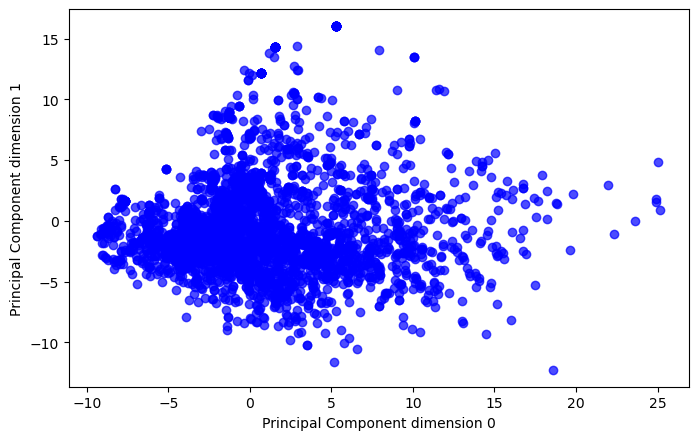

In [19]:
# We can also use the first two components of the PCA to visualise the dataset
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
ax.scatter(X_pca[:,0],X_pca[:,1],color='blue',alpha=0.7)
ax.set_xlabel('Principal Component dimension 0')
ax.set_ylabel('Principal Component dimension 1')

In [20]:
# Generating train test split
X = X_pca
y = semiconductors.band_gap
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [21]:
# Training a random forest model
rf = RandomForestRegressor(n_estimators=500,random_state = 128)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=500, random_state=128)

In [22]:
# Getting some predictions
tr_preds = rf.predict(X_train)
te_preds = rf.predict(X_test)

In [23]:
# Calculate Scores
tr_mse = mse(y_train,tr_preds)
te_mse = mse(y_test,te_preds)
print(f'Train MSE: {tr_mse:.3f} eV | Test MSE: {te_mse:.3f} eV')

Train MSE: 0.336 eV | Test MSE: 1.268 eV


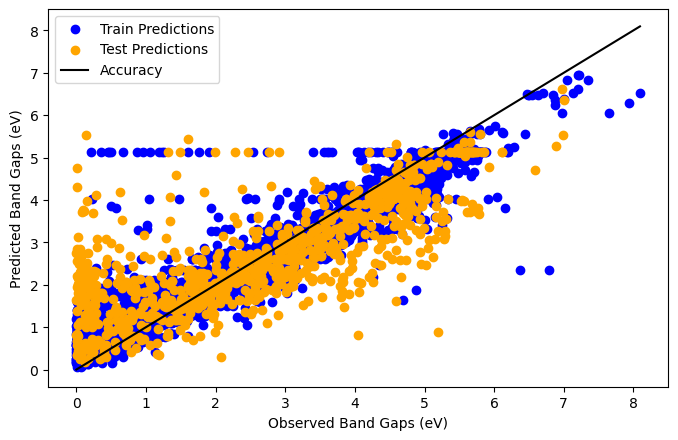

In [24]:
# Plot the first predictions
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
ax.scatter(y_train,tr_preds,color='blue',label='Train Predictions')
ax.scatter(y_test,te_preds,color='orange',label='Test Predictions')
acc = np.linspace(min(y),max(y),1000)
ax.plot(acc,acc,color='k',label='Accuracy')
ax.set_xlabel('Observed Band Gaps (eV)')
ax.set_ylabel('Predicted Band Gaps (eV)')
plt.legend()

Text(0, 0.5, 'Count')

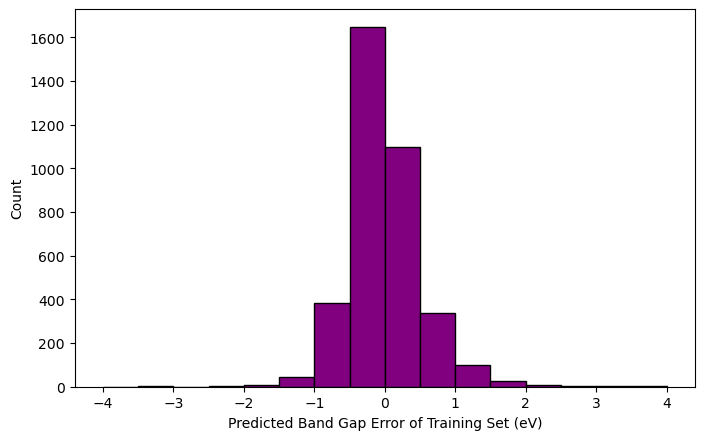

In [25]:
# Distribution of training errors
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
tr_errors = tr_preds - y_train
ax.hist(tr_errors,color='purple',edgecolor='k',bins=np.linspace(-4,4,17))
ax.set_xlabel('Predicted Band Gap Error of Training Set (eV)')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

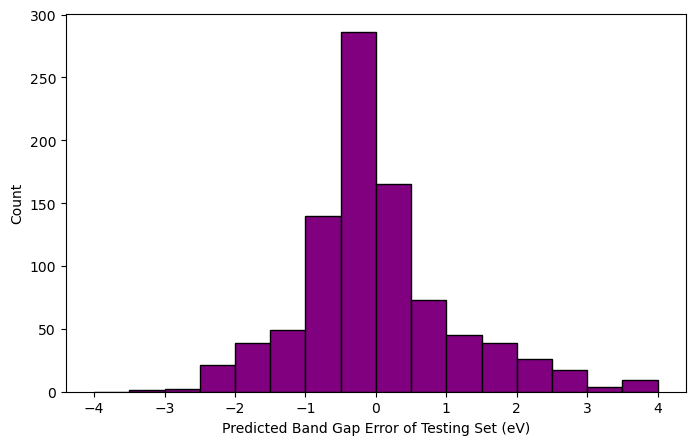

In [26]:
# Distribution of test errors
fig, ax = plt.subplots(figsize=[8,5],dpi=100)
te_errors = te_preds - y_test
ax.hist(te_errors,color='purple',edgecolor='k',bins=np.linspace(-4,4,17))
ax.set_xlabel('Predicted Band Gap Error of Testing Set (eV)')
ax.set_ylabel('Count')

In [27]:
# Improvements that can be made
### Try different machine learning algorithms, hyperparameters, descriptors
### Why not try a classification task, predicting whether a material will be semiconducting or not
### is the prediction accuracy robust, could evaluation of model generalisability be improved?
### what methods can we use to assess how important each descriptor is?

# Some Useful Resources
sklearn: https://scikit-learn.org/stable/
 - GridSearchCV
 - KFold
 - Metrics
 
Pytorch: https://pytorch.org/docs/stable/index.html<br>
Materials Project API: https://docs.materialsproject.org/open-apis/the-materials-api/<br>
dscribe: https://singroup.github.io/dscribe/latest/tutorials/basics.html<br>
matminer.featurizers documentation: https://hackingmaterials.lbl.gov/matminer/matminer.featurizers.html
